In [15]:
import pandas as pd

import numpy as np
from rdkit import Chem
import torch
from torch.utils.data import Dataset

In [16]:
 from submodels.openpom.functions import fragance_propabilities_from_smiles

from numpy.linalg import norm

TARGET_SMILES = "COC1=C(C=CC(=C1)C=O)O"
TARGET_VEC = fragance_propabilities_from_smiles(TARGET_SMILES)[0]

In [17]:
# MCF imports
from molecule_validation import is_odorant, score_molecule

In [18]:

def calculate_score(mol, is_vanilla):
    # Odorant filter + All MCF Filters + Has vanilla scent / 3 (To calculate mean of these params)
    return (is_odorant(mol)[0] + score_molecule(mol).all() + is_vanilla)/3

def calculate_score_online(mol):
    # Odorant filter + All MCF Filters + Has vanilla scent / 3 (To calculate mean of these params)
    return int(is_odorant(mol)[0]) + score_molecule(mol).all()

def hard_filter(mol):
    return int(int(is_odorant(mol)[0]) * score_molecule(mol).all())

In [19]:
torch.tensor([Chem.Descriptors.NumRadicalElectrons(Chem.MolFromSmiles("CCCC")) == 0]).to(torch.bool)

tensor([True])

In [20]:
type(Chem.Descriptors.NumRadicalElectrons(Chem.MolFromSmiles("CCCC")))

int

In [21]:
type(int(hard_filter(Chem.MolFromSmiles("CCCC"))))

int

In [57]:
int(hard_filter(Chem.MolFromSmiles("COC1=C(C=CC(=C1)C=O)O")))==1

True

In [22]:
torch.tensor([int(hard_filter(Chem.MolFromSmiles("CCCC")))==0]).to(torch.bool)

tensor([True])

### Define dataset

In [23]:
class OpenPOMDataset(Dataset):
    def __init__(self, openpom_file="openpomdata.csv", train=True, split_seed=142857, ratio=0.9):
        df = pd.read_csv(openpom_file).drop("descriptors",axis=1)
        df =  df[df['odorless'] == False]
        df = df[df["nonStereoSMILES"].apply(self.explicit_H_filter)].copy()  
        df = df.reset_index(drop=True)

        # Scent corrolation 
        scent_matrix = df[df.keys()[1:]].to_numpy()

        vanilla_idx = list(df.keys()[1:]).index("vanilla")  

        # compute Pearson correlation between vanilla and every other scent
        vanilla_col = scent_matrix[:, vanilla_idx]
        corrs = np.array([np.corrcoef(vanilla_col, scent_matrix[:, i])[0,1] for i in range(138)])
        vanilla_corr_vec = np.nan_to_num(corrs)  # shape: (138,), with NaNs replaced by 0


        scent_cols = df.columns[1:]
        df["reward"]= df[scent_cols].apply(lambda x: self.cosine_similarity(x, vanilla_corr_vec), axis=1)

        # Normalize to [0.1, 1.0] range (or any positive range you like)
        min_r = df["reward"].min()
        max_r = df["reward"].max()

        # Avoid zero reward
        scaled_rewards = 0.1 + 0.9 * (df["reward"] - min_r) / (max_r - min_r)
        df["shift_reward"] = scaled_rewards


        #df = self.generate_scores(df)
        self.df = df
        rng = np.random.default_rng(split_seed)
        idcs = np.arange(len(self.df))
        rng.shuffle(idcs)
        if train:
            self.idcs = idcs[: int(np.floor(ratio * len(self.df)))]
        else:
            self.idcs = idcs[int(np.floor(ratio * len(self.df))) :]
        self.obj_to_graph = lambda x: x
        self.targets = self.df.keys()[1:]

    def setup(self, task, ctx):
        self.obj_to_graph = ctx.obj_to_graph


    def __len__(self):
        return len(self.idcs)

    def __getitem__(self, idx):
        # Returns the RDkit mol object and corresponding 138 scent labels
        m_smiles = self.df["nonStereoSMILES"][self.idcs[idx]]
        return (
            self.obj_to_graph(Chem.MolFromSmiles(m_smiles)),
            #torch.tensor([self.df[t][self.idcs[idx]] for t in self.targets]).float(),
            #torch.tensor([0.5 if self.df['vanilla'][self.idcs[idx]] == 0 else 1]).float(), # 0.5 reward for non vanilla molecues 1 for vanilla molecules
            #torch.tensor([self.compute_reward_from_smiles(m_smiles)]).float()
            #torch.tensor([self.df['score'][self.idcs[idx]]]).float(),
            torch.tensor([self.df['shift_reward'][self.idcs[idx]]]).float(),
        )
    
    def compute_reward_from_smiles(self, m_smiles):
            m_vec = fragance_propabilities_from_smiles(m_smiles)[0]
            return self.cosine_similarity(TARGET_VEC,m_vec)
    
    def cosine_similarity(self,vec1,vec2):
        return np.dot(vec1,vec2)/(norm(vec1)*norm(vec2))
    
    def explicit_H_filter(self, smiles: str) -> bool:
        mol = Chem.MolFromSmiles(smiles)
        for atom in mol.GetAtoms():
            if atom.GetNumExplicitHs() > 1:
                return False  
        return True
    

    
    def generate_scores(self, df):
        df['score'] = df.apply(
            lambda x: calculate_score(
                Chem.MolFromSmiles(x.nonStereoSMILES), 
                x.vanilla
                ), axis=1)
        return df



In [24]:
from gflownet import GFNTask,LogScalar,ObjectProperties
from gflownet.config import Config,init_empty
from typing import Dict, List, Tuple
from torch import Tensor


In [ ]:
class ScentTask(GFNTask):
    def __init__(self, dataset: Dataset, cfg: Config):
        self.dataset = dataset
        self.num_cond_dim = 1
        self.num_objectives = 138

    def sample_conditional_information(self, n: int, train_it: int) -> Dict[str, Tensor]:
        return {"encoding": torch.ones(n, 1)}

    def cond_info_to_logreward(self, cond_info: Dict[str, Tensor], obj_props: ObjectProperties) -> LogScalar:
        #print(obj_props)
        scalar_logreward = torch.as_tensor(obj_props).squeeze().clamp(min=1e-30).log()
        #print(scalar_logreward)
        return LogScalar(scalar_logreward.flatten())
    
    def compute_obj_properties(self, mols):
        is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()
        if not is_valid.any():
            return ObjectProperties(torch.zeros((0,1))), is_valid
        valid_mols = [mol for mol, valid in zip(mols, is_valid) if valid]
        #scores = torch.tensor([calculate_score_online(m) for m in valid_mols])
        rs = torch.tensor(self.compute_reward_from_mols(valid_mols))
        #rs = (rewards+scores) /3
        return ObjectProperties(rs.reshape((-1, 1))), is_valid 
    
        #Attempt for multible scents
        #flat_r = []
        #for m in mols:
        #    flat_r.append(torch.tensor(fragance_propabilities_from_smiles(Chem.MolToSmiles(m))[0]).float())
        #flat_rewards = torch.stack(flat_r, dim=0)
        #return ObjectProperties(flat_rewards), is_valid
    
    def compute_reward_from_mols(self, mols):
        rewards = []
        for m in mols:
            m_smiles = Chem.MolToSmiles(m)
            m_vec = fragance_propabilities_from_smiles(m_smiles)[0]
            rewards.append(self.cosine_similarity(TARGET_VEC,m_vec))
        return rewards
    
    def cosine_similarity(self,vec1,vec2):
        return np.dot(vec1,vec2)/(norm(vec1)*norm(vec2))

In [26]:
from gflownet.online_trainer import StandardOnlineTrainer
import socket
from gflownet.envs.mol_building_env import MolBuildingEnvContext

In [27]:
class ScentTrainer(StandardOnlineTrainer):
    def set_default_hps(self, cfg: Config):
        cfg.hostname = socket.gethostname()
        cfg.algo.method = "TB"
        cfg.algo.max_nodes = 20
        cfg.algo.sampling_tau = 0.9
        cfg.algo.valid_random_action_prob = 0.0
        cfg.num_workers = 8
        cfg.num_training_steps = 100000
        cfg.opt.learning_rate = 1e-6 #1e-4
        cfg.opt.weight_decay = 1e-8
        cfg.opt.momentum = 0.9
        cfg.opt.adam_eps = 1e-8
        cfg.opt.lr_decay = 20000
        cfg.opt.clip_grad_type = "norm"
        cfg.opt.clip_grad_param = 10
        cfg.algo.num_from_policy = 32
        cfg.algo.num_from_dataset = 32
        cfg.algo.train_random_action_prob = 0.001
        cfg.algo.illegal_action_logreward = -75
        cfg.model.num_emb = 128
        cfg.model.num_layers = 4

    def setup_env_context(self):
        self.ctx = MolBuildingEnvContext(
            ['Br', 'C', 'Cl', 'F', 'Fe', 'N', 'Na', 'O', 'S'],
            #["C", "N", "F", "O"],
            #charges=[0],  # disable charge
            chiral_types=[Chem.rdchem.ChiralType.CHI_UNSPECIFIED],  # disable chirality
            expl_H_range=[0,1],
            num_cond_dim=self.task.num_cond_dim,
            max_nodes=self.cfg.algo.max_nodes,
        )

    def setup_data(self):
        self.training_data = OpenPOMDataset(train=True)
        self.test_data = OpenPOMDataset(train=False)

    def setup_task(self):
        self.task = ScentTask(dataset=self.training_data,cfg=self.cfg)

    def setup(self):
        super().setup()
        self.training_data.setup(self.task,self.ctx)
        self.test_data.setup(self.task,self.ctx)




In [28]:
import pathlib

In [29]:
def save_run(trial):
    state = {
        "models_state_dict": [trial.model.state_dict()],
        "cfg": trial.cfg,
        "env_ctx": trial.model.env_ctx,
        #"model": trial.model,
    }
    if trial.sampling_model is not trial.model:
        state["sampling_model_state_dict"] = [trial.sampling_model.state_dict()]
    fn = pathlib.Path(trial.cfg.log_dir) / "model_final_save.pt"
    with open(fn, "wb") as fd:
        torch.save(
            state,
            fd,
        )


In [30]:
config = init_empty(Config())
config.print_every = 1
config.log_dir = "./logs/mcf_mask_invalid_rewards_2"


# For CPU
config.device = torch.device('cpu')
config.num_workers = 0

# For reproduction
config.seed = 1 
config.validate_every=100
config.algo.valid_num_from_policy= 32
config.algo.valid_num_from_dataset= 32
config.num_training_steps = 400 #10_000

config.algo.tb.do_parameterize_p_b = False # Dont know how to load the model with this parameter = True
config.num_validation_gen_steps = 1

config.overwrite_existing_exp=True



trial = ScentTrainer(config)
trial.run()
save_run(trial)

c:\Users\paulj\Desktop\Master\venv\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\paulj\Desktop\Master\venv\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Users\paulj\Desktop\Master\venv\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\paulj\Desktop\Master\venv\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]




Hyperparameters:

desc: noDesc
log_dir: ./logs/mcf_mask_invalid_rewards_2
device: cpu
seed: 1
validate_every: 100
checkpoint_every: null
store_all_checkpoints: false
print_every: 1
start_at_step: 0
num_final_gen_steps: null
num_validation_gen_steps: 1
num_training_steps: 400
num_workers: 0
hostname: LAPTOP-JIE0TNQT
pickle_mp_messages: false
git_hash: e7c59a8
overwrite_existing_exp: true
algo:
  method: TB
  num_from_policy: 32
  num_from_dataset: 32
  valid_num_from_policy: 32
  valid_num_from_dataset: 32
  max_len: 128
  max_nodes: 20
  max_edges: 128
  illegal_action_logreward: -75.0
  train_random_action_prob: 0.001
  train_det_after: null
  valid_random_action_prob: 0.0
  sampling_tau: 0.9
  tb:
    bootstrap_own_reward: false
    epsilon: null
    reward_loss_multiplier: 1.0
    variant: TB
    do_correct_idempotent: false
    do_parameterize_p_b: false
    do_predict_n: false
    do_sample_p_b: false
    do_length_normalize: false
    subtb_max_len: 128
    Z_learning_rate: 0.0

c:\Users\paulj\Desktop\Master\venv\lib\site-packages\gflownet\data\data_source.py:70: UserWarning: Some iterators are done, but not all. You may be mixing incompatible iterators.
  warnings.warn("Some iterators are done, but not all. You may be mixing incompatible iterators.")


23/04/2025 11:56:29 - INFO - logger - validation - iteration 100 : offline_loss:15130.96 online_loss:0.00 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:5.24 loss:15130.96 n_loss:0.00 tb_loss:15130.96 batch_entropy:89.67 traj_lens:17.38 eval_time:1.13
23/04/2025 11:56:30 - INFO - logger - validation - iteration 100 : offline_loss:1314.69 online_loss:0.00 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:5.24 loss:1314.69 n_loss:0.00 tb_loss:1314.69 batch_entropy:58.72 traj_lens:15.28 eval_time:0.87
23/04/2025 11:56:32 - INFO - logger - validation - iteration 100 : offline_loss:1619.39 online_loss:0.00 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:5.24 loss:1619.39 n_loss:0.00 tb_loss:1619.39 batch_entropy:65.16 traj_lens:16.84 eval_time:0.90
23/04/2025 11:56:34 - INFO - logger - validation - iterati

c:\Users\paulj\Desktop\Master\venv\lib\site-packages\gflownet\data\data_source.py:70: UserWarning: Some iterators are done, but not all. You may be mixing incompatible iterators.
  warnings.warn("Some iterators are done, but not all. You may be mixing incompatible iterators.")


23/04/2025 12:13:42 - INFO - logger - validation - iteration 200 : offline_loss:13302.39 online_loss:0.00 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:12.50 loss:13302.39 n_loss:0.00 tb_loss:13302.39 batch_entropy:81.84 traj_lens:17.38 eval_time:1.05
23/04/2025 12:13:45 - INFO - logger - validation - iteration 200 : offline_loss:517.11 online_loss:0.00 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:12.50 loss:517.11 n_loss:0.00 tb_loss:517.11 batch_entropy:51.82 traj_lens:15.28 eval_time:0.76
23/04/2025 12:13:46 - INFO - logger - validation - iteration 200 : offline_loss:621.23 online_loss:0.00 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:12.50 loss:621.23 n_loss:0.00 tb_loss:621.23 batch_entropy:57.26 traj_lens:16.84 eval_time:0.94
23/04/2025 12:13:48 - INFO - logger - validation - iteration 

c:\Users\paulj\Desktop\Master\venv\lib\site-packages\gflownet\data\data_source.py:70: UserWarning: Some iterators are done, but not all. You may be mixing incompatible iterators.
  warnings.warn("Some iterators are done, but not all. You may be mixing incompatible iterators.")


23/04/2025 12:35:54 - INFO - logger - validation - iteration 300 : offline_loss:11968.63 online_loss:0.00 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:15.75 loss:11968.63 n_loss:0.00 tb_loss:11968.63 batch_entropy:76.38 traj_lens:17.38 eval_time:1.05
23/04/2025 12:35:56 - INFO - logger - validation - iteration 300 : offline_loss:234.00 online_loss:0.00 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:15.75 loss:234.00 n_loss:0.00 tb_loss:234.00 batch_entropy:47.48 traj_lens:15.28 eval_time:0.82
23/04/2025 12:35:58 - INFO - logger - validation - iteration 300 : offline_loss:267.21 online_loss:0.00 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:15.75 loss:267.21 n_loss:0.00 tb_loss:267.21 batch_entropy:51.72 traj_lens:16.84 eval_time:0.88
23/04/2025 12:36:00 - INFO - logger - validation - iteration 

c:\Users\paulj\Desktop\Master\venv\lib\site-packages\gflownet\data\data_source.py:70: UserWarning: Some iterators are done, but not all. You may be mixing incompatible iterators.
  warnings.warn("Some iterators are done, but not all. You may be mixing incompatible iterators.")


23/04/2025 13:03:34 - INFO - logger - validation - iteration 400 : offline_loss:11850.33 online_loss:0.00 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:18.17 loss:11850.33 n_loss:0.00 tb_loss:11850.33 batch_entropy:73.00 traj_lens:17.38 eval_time:1.04
23/04/2025 13:03:36 - INFO - logger - validation - iteration 400 : offline_loss:111.38 online_loss:0.00 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:18.17 loss:111.38 n_loss:0.00 tb_loss:111.38 batch_entropy:44.62 traj_lens:15.28 eval_time:0.85
23/04/2025 13:03:38 - INFO - logger - validation - iteration 400 : offline_loss:148.68 online_loss:0.00 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:18.17 loss:148.68 n_loss:0.00 tb_loss:148.68 batch_entropy:49.32 traj_lens:16.84 eval_time:1.01
23/04/2025 13:03:40 - INFO - logger - validation - iteration 

In [31]:
from rdkit.Chem.Draw import MolsToGridImage, MolToImage

In [32]:
(335.69 + 153.25)/2

244.47

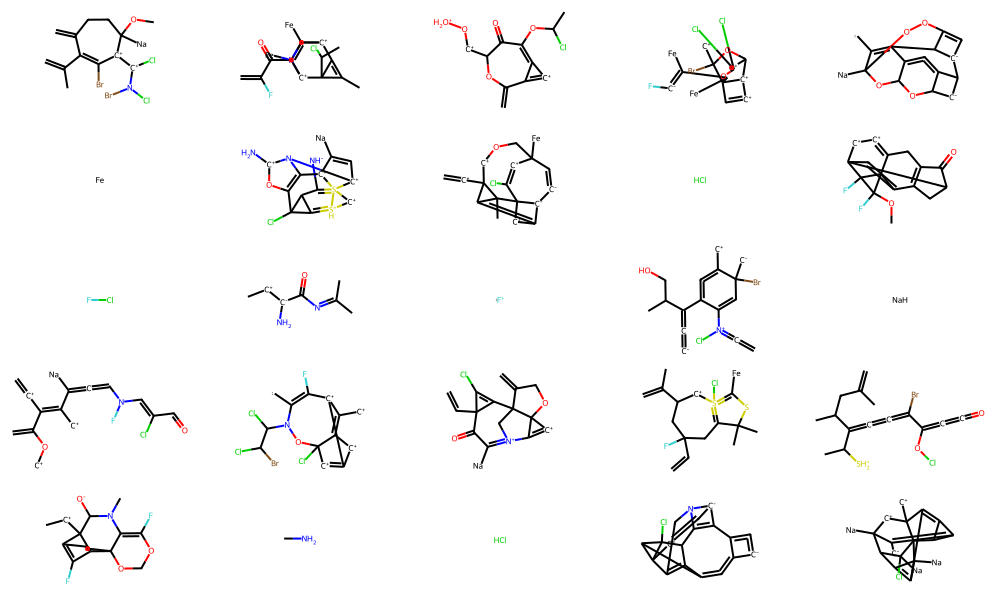

In [33]:
# Generate molecules
trajs = trial.algo.create_training_data_from_own_samples(trial.model, 25)
objs = [trial.ctx.graph_to_obj(i['result']) for i in trajs]
obj_props, is_valid = trial.task.compute_obj_properties(objs)
cond_info = trial.task.sample_conditional_information(len(obj_props), 1)
log_rewards = trial.task.cond_info_to_logreward(cond_info, obj_props)


MolsToGridImage(objs[:25], molsPerRow=5, subImgSize=(200, 120))#, legends=[f'reward: {r.exp().item():.2f}' for r in log_rewards[:25]])

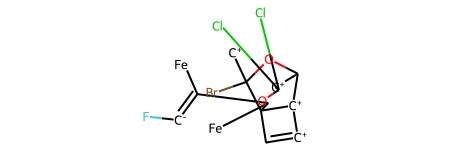

In [34]:
objs[3]

In [ ]:
#ea.Tags()

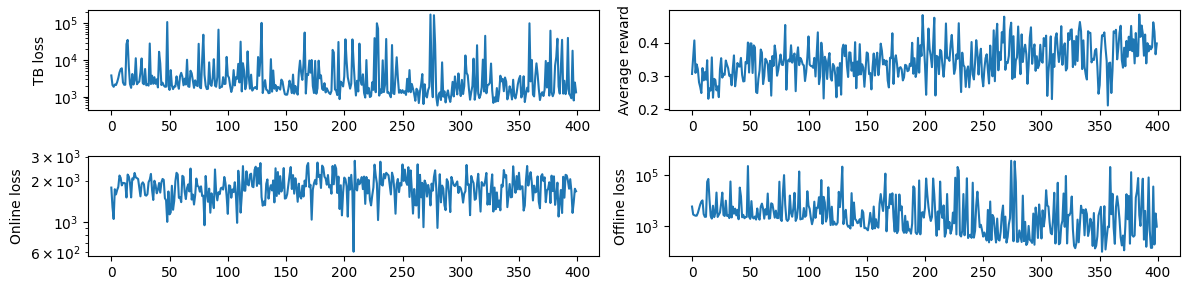

In [35]:
from gflownet.config import init_empty, Config
cfg = init_empty(Config())
from tensorboard.backend.event_processing import event_accumulator

cfg.log_dir = config.log_dir
ea = event_accumulator.EventAccumulator(cfg.log_dir)
ea.Reload()

import matplotlib.pyplot as pp
f, ax = pp.subplots(2, 2, figsize=(4*3,3))
ax[0,0].plot([i.value for i in ea.Scalars('train_loss')])
ax[0,0].set_yscale('log')
ax[0,0].set_ylabel('TB loss')
ax[0,1].plot([i.value for i in ea.Scalars('train_sampled_reward_avg')])
ax[0,1].set_ylabel('Average reward')
#ax[0,2].plot([i.value for i in ea.Scalars('train_logZ')])
#ax[0,2].set_ylabel('Predicted logZ')
ax[1,0].plot([i.value for i in ea.Scalars('train_online_loss')])
ax[1,0].set_yscale('log')
ax[1,0].set_ylabel('Online loss')
ax[1,1].plot([i.value for i in ea.Scalars('train_offline_loss')])
ax[1,1].set_yscale('log')
ax[1,1].set_ylabel('Offline loss')
#ax[2,0].plot([i.value for i in ea.Scalars('valid_online_loss')])
#ax[2,0].set_yscale('log')
#ax[2,0].set_ylabel('Validation online loss')
#ax[2,1].plot([i.value for i in ea.Scalars('valid_offline_loss')])
#ax[2,1].set_yscale('log')
#ax[2,1].set_ylabel('Validation offline loss')
pp.tight_layout()

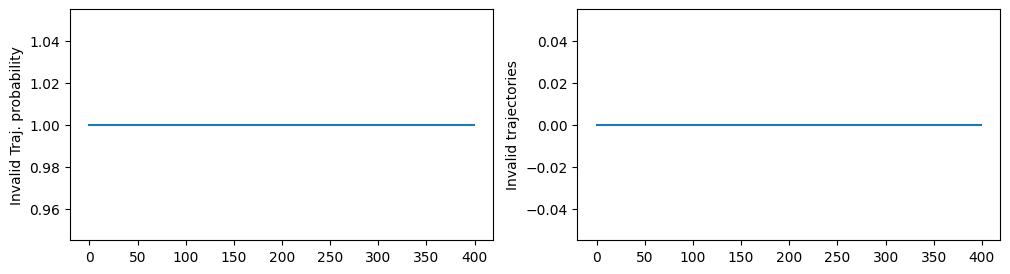

In [ ]:
f, ax = pp.subplots(1, 2, figsize=(4*3,3))
ax[0].plot([np.exp(i.value) for i in ea.Scalars('train_invalid_logprob')])

ax[0].set_ylabel('Invalid Traj. probability')
ax[1].plot([i.value for i in ea.Scalars('train_invalid_trajectories')])
ax[1].set_ylabel('Invalid trajectories')

pp.show()

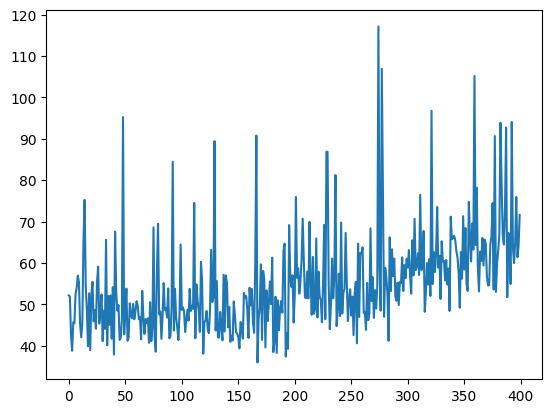

In [53]:

pp.plot([i.value for i in ea.Scalars('train_batch_entropy')])



pp.show()

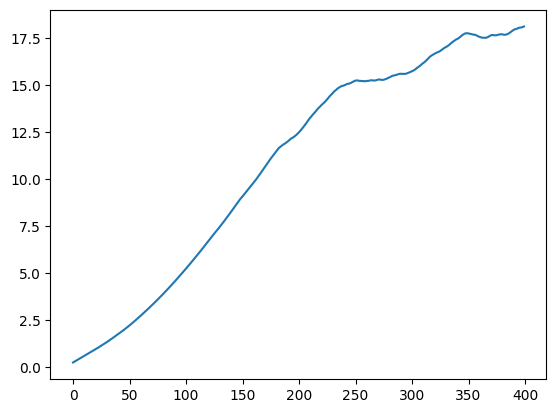

In [54]:

pp.plot([i.value for i in ea.Scalars('train_logZ')])



pp.show()

In [52]:
ea.Scalars('train_batch_entropy')

[ScalarEvent(wall_time=1745401254.7500746, step=1, value=52.15933609008789),
 ScalarEvent(wall_time=1745401266.0944078, step=2, value=51.90633773803711),
 ScalarEvent(wall_time=1745401274.2354002, step=3, value=42.30292510986328),
 ScalarEvent(wall_time=1745401280.5301433, step=4, value=38.77125930786133),
 ScalarEvent(wall_time=1745401289.4402065, step=5, value=45.65122604370117),
 ScalarEvent(wall_time=1745401298.02905, step=6, value=45.41991424560547),
 ScalarEvent(wall_time=1745401307.7218323, step=7, value=52.46413040161133),
 ScalarEvent(wall_time=1745401317.3721287, step=8, value=53.924713134765625),
 ScalarEvent(wall_time=1745401326.7217915, step=9, value=56.9300537109375),
 ScalarEvent(wall_time=1745401340.060825, step=10, value=55.3052978515625),
 ScalarEvent(wall_time=1745401354.0361583, step=11, value=45.35417938232422),
 ScalarEvent(wall_time=1745401363.5804398, step=12, value=42.016571044921875),
 ScalarEvent(wall_time=1745401373.49511, step=13, value=45.40324783325195),


In [18]:
max([i.value for i in ea.Scalars('train_sampled_reward_avg')])

0.6843580007553101

In [ ]:
cfg.log_dir+"/train/"

In [ ]:
!dir ./logs/dataload_2/train/

In [36]:
import sqlite3
import pandas as pd
from rdkit.Chem.Draw import MolsToGridImage, MolToImage

In [37]:
conn = sqlite3.connect(f"{cfg.log_dir}/train/generated_objs_0.db")

In [38]:
df = pd.read_sql_query("SELECT * FROM results", conn)

In [39]:
import numpy as np

In [42]:
idx_list = sorted([j*32 -i -1  for j in [100,200,300,400] for i in range(5)])

In [43]:
choosendf = df.iloc[idx_list]

In [44]:
top_rewards = df.sort_values(by='r', ascending=False).head(25)


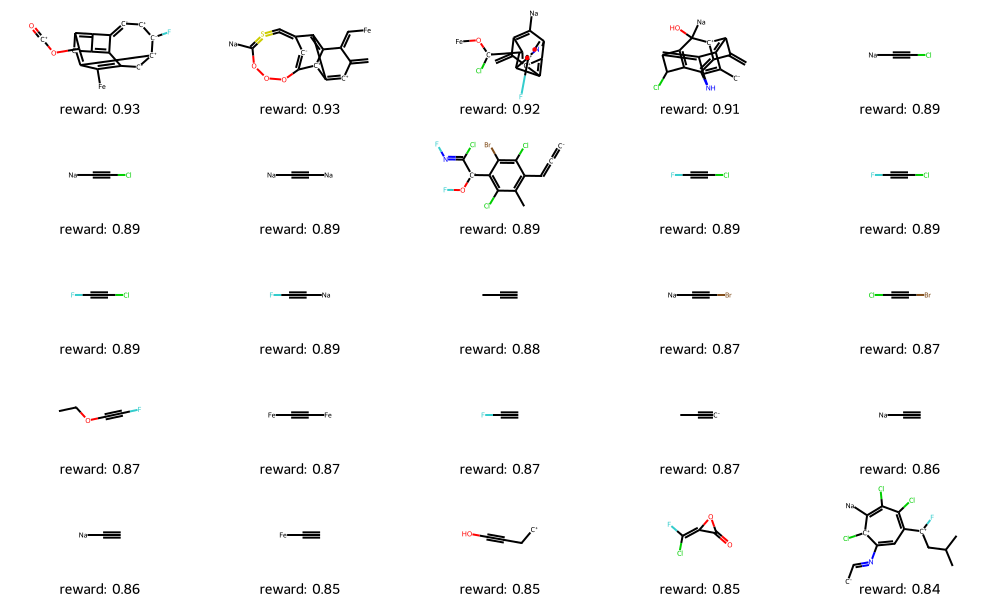

In [45]:
# Generate molecules
objs = [Chem.MolFromSmiles(smiles) for smiles in top_rewards["smi"]]
rewards = top_rewards["r"]


MolsToGridImage(objs[:25], molsPerRow=5, subImgSize=(200, 120), legends=[f'reward: {r:.2f}' for r in rewards[:25]])

In [46]:
df['iteration'] = df.index // 32

# Compute mean of desired columns per iteration
# Example: mean reward per iteration
# Replace 'reward' with your actual column name
mean_per_iter = df.groupby('iteration')['r'].mean()
mean_per_iter

iteration
0      0.306257
1      0.358398
2      0.406333
3      0.309419
4      0.334813
         ...   
395    0.386150
396    0.460440
397    0.432570
398    0.364930
399    0.397277
Name: r, Length: 400, dtype: float64

In [47]:
import matplotlib.pyplot as plt

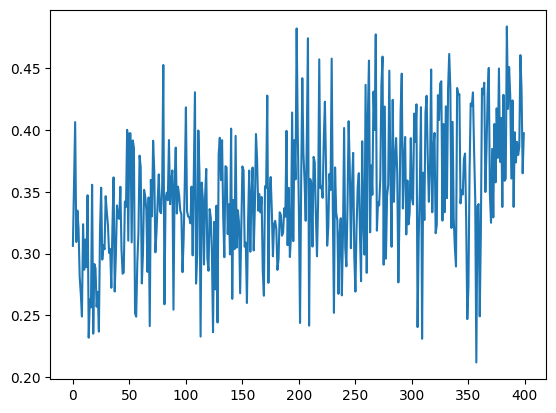

In [48]:
plt.plot(mean_per_iter)

In [ ]:
from rdkit import Chem

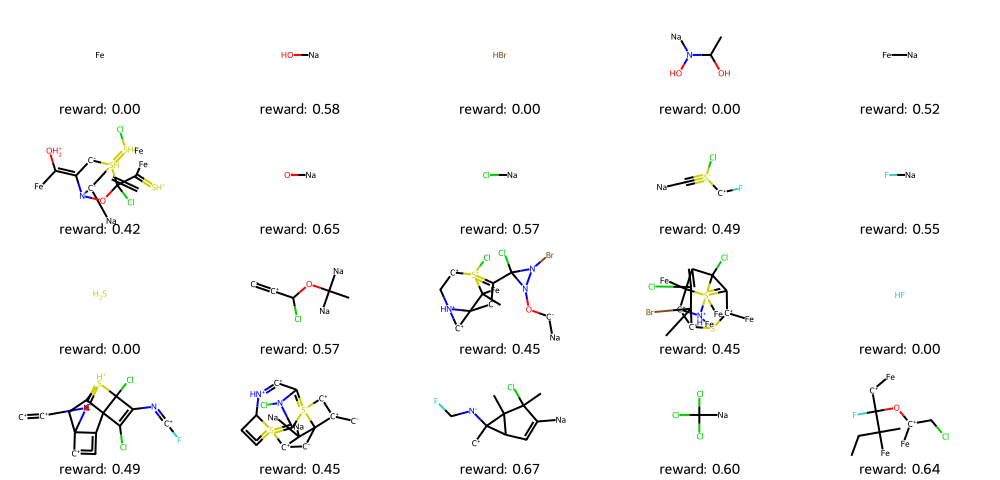

In [49]:
# Generate molecules
objs = [Chem.MolFromSmiles(smiles) for smiles in choosendf["smi"]]
rewards = choosendf["r"]


MolsToGridImage(objs[:25], molsPerRow=5, subImgSize=(200, 120), legends=[f'reward: {r:.2f}' for r in rewards[:25]])

---------------------------------------------------------------------------
ValueError                                Traceback (most recent call last)
Cell In[10], line 23
     18 config.overwrite_existing_exp=True
     22 trial = ScentTrainer(config)
---> 23 trial.run()
     24 save_run(trial)

File c:\Users\paulj\Desktop\Master\venv\lib\site-packages\gflownet\trainer.py:271, in GFNTrainer.run(self, logger)
    269 logger.info("Starting training")
    270 start_time = time.time()
--> 271 for it, batch in zip(range(start, 1 + num_training_steps), cycle(train_dl)):
    272     # the memory fragmentation or allocation keeps growing, how often should we clean up?
    273     # is changing the allocation strategy helpful?
    275     if it % 1024 == 0:
    276         gc.collect()

File c:\Users\paulj\Desktop\Master\venv\lib\site-packages\gflownet\trainer.py:377, in cycle(it)
    375 def cycle(it):
    376     while True:
--> 377         for i in it:
    378             yield i

File c:\Users\paulj\Desktop\Master\venv\lib\site-packages\torch\utils\data\dataloader.py:708, in _BaseDataLoaderIter.__next__(self)
    705 if self._sampler_iter is None:
    706     # TODO(https://github.com/pytorch/pytorch/issues/76750)
    707     self._reset()  # type: ignore[call-arg]
--> 708 data = self._next_data()
    709 self._num_yielded += 1
    710 if (
    711     self._dataset_kind == _DatasetKind.Iterable
    712     and self._IterableDataset_len_called is not None
    713     and self._num_yielded > self._IterableDataset_len_called
    714 ):

File c:\Users\paulj\Desktop\Master\venv\lib\site-packages\torch\utils\data\dataloader.py:764, in _SingleProcessDataLoaderIter._next_data(self)
    762 def _next_data(self):
    763     index = self._next_index()  # may raise StopIteration
--> 764     data = self._dataset_fetcher.fetch(index)  # may raise StopIteration
    765     if self._pin_memory:
    766         data = _utils.pin_memory.pin_memory(data, self._pin_memory_device)

File c:\Users\paulj\Desktop\Master\venv\lib\site-packages\torch\utils\data\_utils\fetch.py:42, in _IterableDatasetFetcher.fetch(self, possibly_batched_index)
     40         raise StopIteration
     41 else:
---> 42     data = next(self.dataset_iter)
     43 return self.collate_fn(data)

File c:\Users\paulj\Desktop\Master\venv\lib\site-packages\gflownet\data\data_source.py:80, in DataSource.__iter__(self)
     78 for d in batch_infos:
     79     batch_info.update(d)
---> 80 yield self.create_batch(trajs, batch_info)

File c:\Users\paulj\Desktop\Master\venv\lib\site-packages\gflownet\data\data_source.py:220, in DataSource.create_batch(self, trajs, batch_info)
    218 ci = torch.stack([t["cond_info"]["encoding"] for t in trajs])
    219 log_rewards = torch.stack([t["log_reward"] for t in trajs])
--> 220 batch = self.algo.construct_batch(trajs, ci, log_rewards)
    221 batch.num_online = sum(t.get("is_online", 0) for t in trajs)
    222 batch.num_offline = len(trajs) - batch.num_online

File c:\Users\paulj\Desktop\Master\venv\lib\site-packages\gflownet\algo\trajectory_balance.py:311, in TrajectoryBalance.construct_batch(self, trajs, cond_info, log_rewards)
    307     actions = [
    308         self.ctx.GraphAction_to_ActionIndex(g, i[1]) for g, tj in zip(torch_graphs, trajs) for i in tj["traj"]
    309     ]
    310 else:
--> 311     torch_graphs = [self.ctx.graph_to_Data(i[0]) for tj in trajs for i in tj["traj"]]
    312     actions = [
    313         self.ctx.GraphAction_to_ActionIndex(g, a)
    314         for g, a in zip(torch_graphs, [i[1] for tj in trajs for i in tj["traj"]])
    315     ]
    316 batch = self.ctx.collate(torch_graphs)

File c:\Users\paulj\Desktop\Master\venv\lib\site-packages\gflownet\algo\trajectory_balance.py:311, in <listcomp>(.0)
    307     actions = [
    308         self.ctx.GraphAction_to_ActionIndex(g, i[1]) for g, tj in zip(torch_graphs, trajs) for i in tj["traj"]
    309     ]
    310 else:
--> 311     torch_graphs = [self.ctx.graph_to_Data(i[0]) for tj in trajs for i in tj["traj"]]
    312     actions = [
    313         self.ctx.GraphAction_to_ActionIndex(g, a)
    314         for g, a in zip(torch_graphs, [i[1] for tj in trajs for i in tj["traj"]])
    315     ]
    316 batch = self.ctx.collate(torch_graphs)

File c:\Users\paulj\Desktop\Master\venv\lib\site-packages\gflownet\envs\mol_building_env.py:280, in MolBuildingEnvContext.graph_to_Data(self, g)
    277     remove_node_mask[i] = 1
    278 for k, sl in zip(self.atom_attrs, self.atom_attr_slice):
    279     # idx > 0 means that the attribute is not the default value
--> 280     idx = self.atom_attr_values[k].index(ad[k]) if k in ad else 0
    281     x[i, sl + idx] = 1
    282     if k == "v":

ValueError: 1 is not in list